# Import

In [1]:
# Importing the necessary libraries
import requests
import pandas as pd

# Activity 1

## 1.1 Sub-activity: Open Data API

### Task 1

In [2]:
# The implementation of this function is taken from the documentation provided:
# https://ukhsa-dashboard.data.gov.uk/access-our-data/examples-api-pagination.

# Function to fetch data from the passed url.
def get_api_data(url, page_size=365):
    data = []
    while url:
        # the requests package is used to make an HTTP request to our current URL
        response = requests.get(url, params={"page_size": page_size})

        if not response.ok:
            raise Exception("Error, request failed.")

        # we parse our response as JSON
        response_data = response.json()
        
        # checking if results and next are present in the response, else throwing error
        if "results" not in response_data or "next" not in response_data:
            raise KeyError("Unexpected response format: 'results' or 'next' key missing.")
        
        # then take the next and results items from the response object
        results = response_data["results"]
        next_url = response_data["next"]

        data.extend(results)
        url = next_url

    return data

### Task 2

In [3]:
# API URLs for England's Data
england_daily_cases_data_url = "https://api.ukhsa-dashboard.data.gov.uk/themes/infectious_disease/sub_themes/respiratory/topics/COVID-19/geography_types/Nation/geographies/England/metrics/COVID-19_cases_casesByDay"
england_daily_deaths_data_url = "https://api.ukhsa-dashboard.data.gov.uk/themes/infectious_disease/sub_themes/respiratory/topics/COVID-19/geography_types/Nation/geographies/England/metrics/COVID-19_deaths_ONSByDay"

# Fetching daily cases and daily deaths for England from the API function
cases_data = get_api_data(england_daily_cases_data_url)
deaths_data = get_api_data(england_daily_deaths_data_url)

# Empty list initialized to store dictionaries for the fetched data
aggregated_data = []

# Creating a dictionary of deaths data indexed by date for faster lookup
deaths_data_by_date = {entry["date"]: entry["metric_value"] for entry in deaths_data}

# Iterating through the daily cases data to combine with daily deaths data
for case_entry in cases_data:
    case_date = case_entry["date"]
    geography = case_entry["geography"]  
    daily_cases = case_entry["metric_value"]
    
    # Searching the corresponding daily deaths value using the date
    daily_deaths = deaths_data_by_date.get(case_date)
    
    # Adding the data fetched from the 2 APIs to the list as a dictionary object.
    aggregated_data.append({
        "geography": geography,
        "date": case_date,
        "metric_value_cases": daily_cases,
        "metric_value_deaths": daily_deaths
    })
    
# Converting the aggregated data into a DataFrame
england_df = pd.DataFrame(aggregated_data)

# Saving the DataFrame to a JSON file
england_df.to_json("results_json_england.json", orient="records", indent=4)

print("England's Data successfully saved to 'results_json_england.json'.")

England's Data successfully saved to 'results_json_england.json'.


In [4]:
# List of region names ( These region names were used from this: https://api.ukhsa-dashboard.data.gov.uk/themes/infectious_disease/sub_themes/respiratory/topics/COVID-19/geography_types/Government%20Office%20Region/geographies )
region_names = ["East Midlands", "East of England", "London", "North East", "North West", "South East", "South West", "West Midlands", "Yorkshire and The Humber"]

# Base URL for regional data
base_url = "https://api.ukhsa-dashboard.data.gov.uk/themes/infectious_disease/sub_themes/respiratory/topics/COVID-19/geography_types/Government%20Office%20Region/geographies/{}/metrics/COVID-19_deaths_ONSByDay"

# Empty list initialized to store dictionaries for the fetched data
regional_data = []

# Iterating in the different regions available
for region_name in region_names:
    # Constructing the url for each region name
    region_url = base_url.format(region_name.replace(" ", "%20"))  # Replace spaces with %20 for URL encoding
    
    # Fetching the data of region from the API
    region_deaths_data = get_api_data(region_url)
    
    # Appending region data to the regional data
    for entry in region_deaths_data:
        regional_data.append({ 
            "geography": region_name,
            "date": entry["date"],
            "metric_value": entry["metric_value"]
        })

# Converting the regional data into a DataFrame  - as asked in Task 3
regions_df = pd.DataFrame(regional_data)

# Saving the DataFrame to a JSON file
regions_df.to_json("results_json_regional.json", orient="records", indent=4)

print("Region's Data successfully saved to 'results_json_regional.json'.")

Region's Data successfully saved to 'results_json_regional.json'.


## 1.2 Sub-activity: Shaping the COVID data into different dataframes

### Task 3

In [5]:
#  Task 3 Already done in Task 2. Regions Data was stored in regions_df data frame

# Also for England's data it was also stored in england_df data frame.

### Task 4

In [6]:
# Renaming the columns to ’Region’, and ’daily deaths’
regions_df.rename(columns={"geography":"Region","metric_value": "daily_deaths"}, inplace=True)

### Task 5

In [7]:
# Converting the 'date' column to datetime
regions_df["date"] = pd.to_datetime(regions_df["date"])

# Checking if the column type has been changed. 
print(regions_df.dtypes)

Region                  object
date            datetime64[ns]
daily_deaths           float64
dtype: object


### Task 6

In [8]:
# Printing the summary of the dataframe
print("\nSummary of DataFrame:\n")
print(regions_df.info())

# For Additional Descriptive statistics
print("\nSummary of Statistics:\n", regions_df.describe())


Summary of DataFrame:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12996 entries, 0 to 12995
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Region        12996 non-null  object        
 1   date          12996 non-null  datetime64[ns]
 2   daily_deaths  12996 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 304.7+ KB
None

Summary of Statistics:
                                 date  daily_deaths
count                          12996  12996.000000
mean   2022-01-20 11:59:59.999999744     15.309403
min              2020-01-30 00:00:00      0.000000
25%              2021-01-24 18:00:00      3.000000
50%              2022-01-20 12:00:00      7.000000
75%              2023-01-16 06:00:00     14.000000
max              2024-01-12 00:00:00    327.000000
std                              NaN     28.393523


In [9]:
# Calculating the amount of missing data in each column
missing_data = regions_df.isnull().sum()
print("\nMissing Data Summary:")
print(missing_data)

# We measure the amount of missing data by counting NaN values in each column. This isnull().sum() method
# gives us the total count of NaN rows in each column, which shows the total missing data


Missing Data Summary:
Region          0
date            0
daily_deaths    0
dtype: int64


### Task 7

In [10]:
# Checking for the missing data
print("Missing data before removal:")
print(england_df.isnull().sum())
rows_before_deletion = len(england_df)

# Dropping the rows with missing data
england_df.dropna(inplace=True)

# Verifying if the missing data has been successfully removed
print("\nMissing data after removal:")
print(england_df.isnull().sum())
rows_after_deletion = len(england_df)

print(f"\n\nThe total Number of rows deleted are {rows_before_deletion-rows_after_deletion}.")

Missing data before removal:
geography                0
date                     0
metric_value_cases       0
metric_value_deaths    334
dtype: int64

Missing data after removal:
geography              0
date                   0
metric_value_cases     0
metric_value_deaths    0
dtype: int64


The total Number of rows deleted are 334.


### Task 8

In [11]:
rolling_window_size = 7

# Calculating 7 day average value for daily cases and storing in a new column
england_df["daily_cases_roll_avg"] = [
    england_df["metric_value_cases"].iloc[max(0, i - rolling_window_size + 1): i + 1].mean()
    for i in range(len(england_df))
]
# Calculating 7 day average value for daily deaths and storing in a new column
england_df["daily_deaths_roll_avg"] = [
    england_df["metric_value_deaths"].iloc[max(0, i - rolling_window_size + 1): i + 1].mean()
    for i in range(len(england_df))
]

# Displaying the updated dataframe to verify if columns have been added
england_df.head(10)

,geography,date,metric_value_cases,metric_value_deaths,daily_cases_roll_avg,daily_deaths_roll_avg
0,England,2020-01-30,1.0,1.0,1.000000,1.000000
1,England,2020-01-31,0.0,0.0,0.500000,0.500000
2,England,2020-02-01,0.0,0.0,0.333333,0.333333
3,England,2020-02-02,1.0,1.0,0.500000,0.500000
4,England,2020-02-03,18.0,0.0,4.000000,0.400000
5,England,2020-02-04,0.0,0.0,3.333333,0.333333
6,England,2020-02-05,1.0,0.0,3.000000,0.285714
7,England,2020-02-06,0.0,0.0,2.857143,0.142857
8,England,2020-02-07,0.0,0.0,2.857143,0.142857
9,England,2020-02-08,3.0,0.0,3.285714,0.142857


## 1.3 Sub-activity: Aggregating, plotting, and analysing

### Task 9

<Axes: title={'center': 'Daily COVID-19 Deaths in London Over Time'}, xlabel='Date', ylabel='Daily Deaths'>

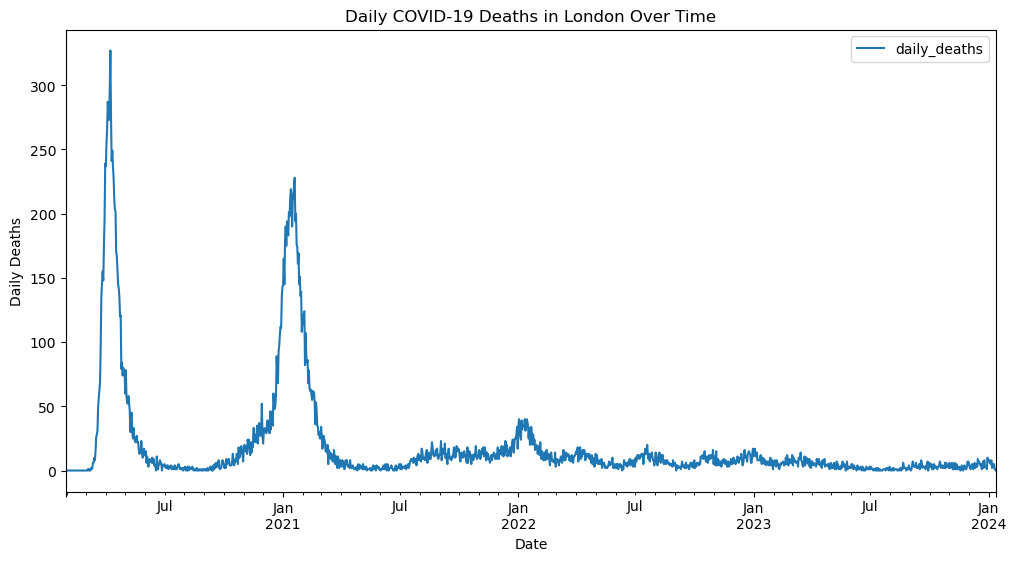

In [12]:
FIG_SIZE = (12,6) # This figure size will be used for the all the upcoming figures.

# Show the daily cases in London as they evolve through time.

# 1. 
# Filtering the dataframe for daily deaths for london
london_cases_df = regions_df[regions_df["Region"] == "London"] 

# 2.
# Setting date as the index for time-series plotting
london_cases_df.set_index("date").plot(
    title="Daily COVID-19 Deaths in London Over Time",  
    ylabel="Daily Deaths", 
    xlabel="Date", 
    figsize= FIG_SIZE, 
)

# 3. Is there a period in time in which the cases plateaued?

# As we can see in the figure below there are periods in which the daily deaths have been plateaued. After the 
# first major peak in early 2020, there was a plateau in deaths until the end of 2020, and after the second peak 
# we can see a noticeable plateau from the mid of 2021 onwards to the late 2023, with minor fluctuations showing 
# a lower number of daily deaths.

### Task 10

<Axes: title={'center': 'Daily COVID-19 Deaths Summed Over All Regions'}, xlabel='Date', ylabel='Daily Deaths'>

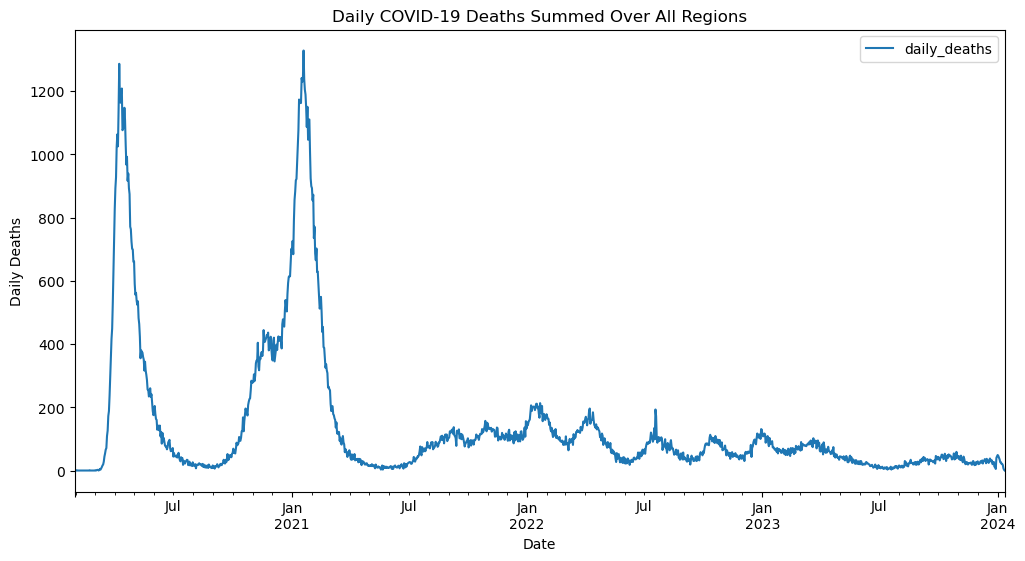

In [13]:
# Show the evolution through time of daily cases summed over all areas.

# 1. 
# Group by date and calculating the sum of daily cases across all regions
daily_cases_sum_df = regions_df.groupby("date")["daily_deaths"].sum().reset_index()


# 2. Plot to visualize the transformed data.
daily_cases_sum_df.set_index("date").plot( # Setting date as the index for time-series plotting
    title="Daily COVID-19 Deaths Summed Over All Regions",  # Title of the plot
    ylabel="Daily Deaths",  # Label for y-axis
    xlabel="Date",  # Label for x-axis
    figsize= FIG_SIZE,  # Size of the figure
    
)

# 3. How does the pattern seen in London hold country-wide?

# The country wide data exhibits patterns very similar to that of London, synchronized peaks can be seen in the
# beginning of 2020 and 2021, with larger number of daily deaths for nation-wide. Similarly, the plateau periods for 
# london and country-wide are almost the same, particularly from the middle of 2021. This confirms that the rise in 
# and drops in the daily deaths for COVID-19 were coherent country-wide.

### Task 11

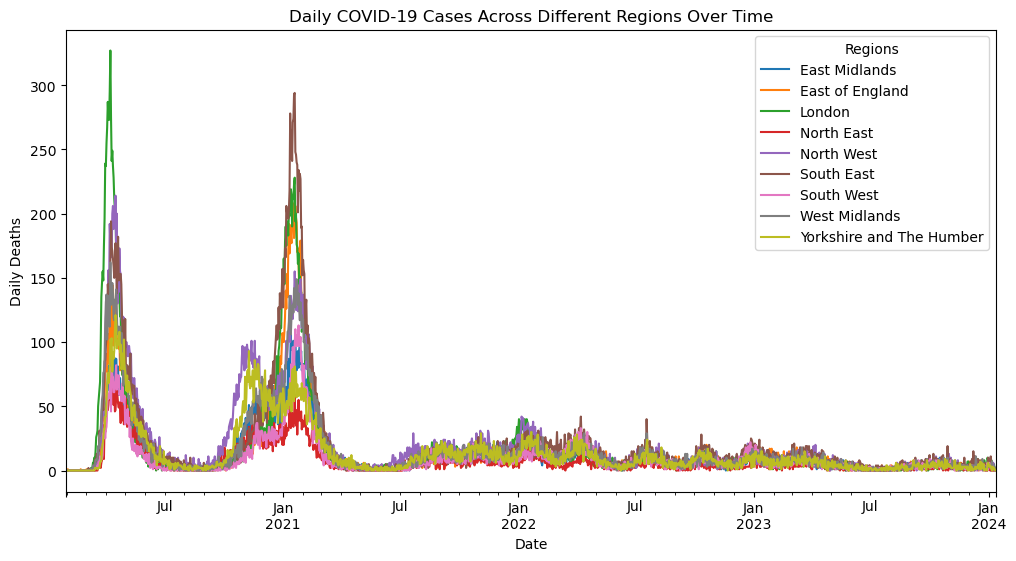

In [14]:
# Now, instead of summing the data over areas, show us the evolution of daily cases of different areas as different lines in a plot.

# 1.
# No aggregation / transformation of data required.

# 2. Plotting the data
# Grouping the data  by 'Region' and plotting each region's daily cases as a separate line
ax = None
for region, data in regions_df.groupby("Region"):
    ax = data.plot(
        title="Daily COVID-19 Cases Across Different Regions Over Time",
        y="daily_deaths",
        x="date",
        ax=ax,  # Same axis is being used for all the regions.
        label=region,  
        figsize=FIG_SIZE 
    )
# Adding labels for the figure
ax.set_ylabel("Daily Deaths")
ax.set_xlabel("Date")
ax.legend(title="Regions") # Adding legend to show which line represent which region


# 3. What patterns do all nations/regions share?

# The plot reveals several shared patterns in the evolution of daily COVID-19 deaths across different regions.
# All regions experienced synchronized surges during major waves, particularly in early 2020 and early 2021, 
# reflecting nationwide increase in deaths. Immediately after both these peaks the number of deaths decline significantly, 
# by mid-2020 and mid-2021. After the mid of 2021, we can see very similar fluctuations in daily deaths in all the 
# regions .

### Task 12

<Axes: title={'center': 'Daily COVID-19 Deaths in England Over Time'}, xlabel='Date', ylabel='Daily Deaths'>

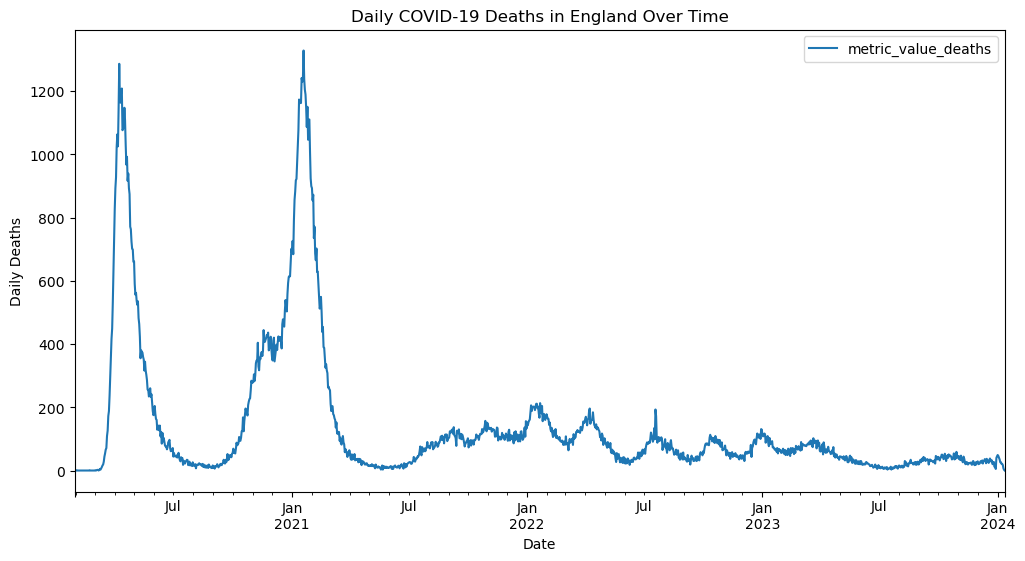

In [15]:
# Show us the evolution of daily deaths in England through time.
england_df["date"] = pd.to_datetime(england_df["date"]) # converting the data type of date column to date & time for plotting

# 1.
# Extracting the date and daily deaths columns from the england data frame. 
england_daily_deaths = england_df[["date", "metric_value_deaths"]]

# 2. Plotting the data
england_daily_deaths.set_index("date").plot(
    title="Daily COVID-19 Deaths in England Over Time",
    ylabel="Daily Deaths",
    xlabel="Date",
    figsize=FIG_SIZE
)

# 3. Is there a noticeable period in time when the ongoing trend is broken? When?

# There are  noticeable instances where the trend of daily deaths is broken. The trend was broken right after
# the number of daily deaths peaked during early 2020s and 2021s. When the daily deaths were max, they were brought to a
# minimum within a span of 2-3 months. And from there onwards the trend remained broken with minor fluctuations. 


### Task 13

<Axes: title={'center': 'Daily COVID-19 cases in England Over Time'}, xlabel='Date', ylabel='Daily Cases'>

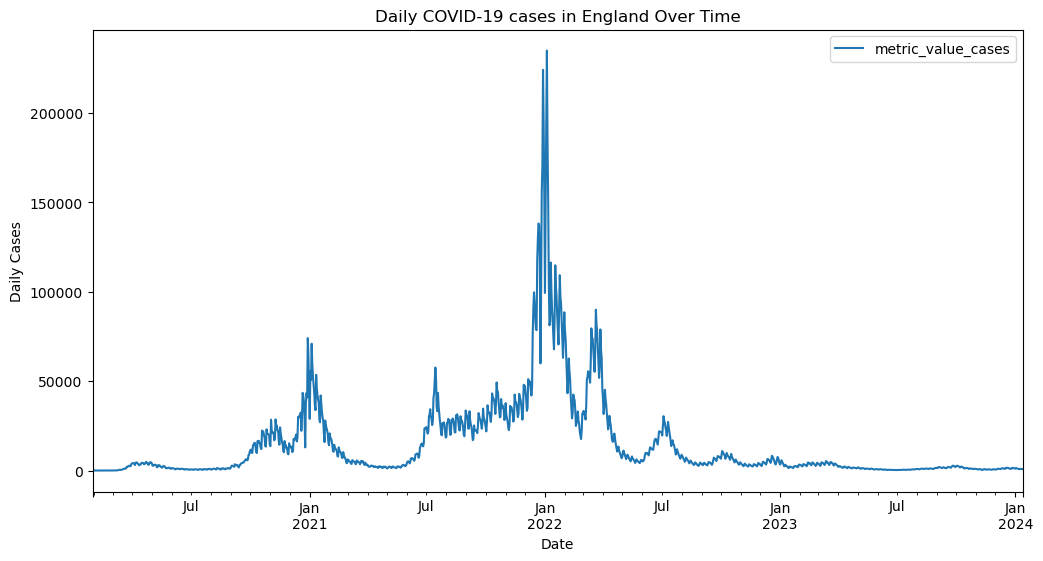

In [16]:
# Show us the evolution of daily cases in England through time.

# 1. 
# Extracting the date and daily cases columns from the england data frame. 
england_daily_cases = england_df[["date", "metric_value_cases"]]

# 2. Plotting the data
england_daily_cases.set_index("date").plot(
    title="Daily COVID-19 cases in England Over Time",
    ylabel="Daily Cases",
    xlabel="Date",
    figsize=FIG_SIZE
)

# 3. Based on the data and plot from the last question, is there any similarity between trends in cumulative 
# cases and cumulative deaths?

# There is a clear similarity between the trends in daily cases and daily deaths. When daily cases increase,
# there is a corresponding rise in deaths, and vice versa. For instance, in early 2021, as daily cases approached 
# 75,000, daily deaths exceeded 1,200. By mid-2021, a significant decline in daily cases led to a steep drop in 
# daily deaths. However, in early 2022, while daily cases exceeded 200,000, the rise in deaths was comparatively 
# smaller, reflecting the impact of using vaccinations.